# Face Recognition Assignment #1

## Problem Statement 

We intend to perform face recognition. Face recognition means that for a given image
you can tell the subject id. Our database of subject is very simple. It has 40 subjects.
Below we will show the needed steps to achieve the goal of the assignment.

### Step 1: Download the dataset and understand the format 

In [0]:
from os import listdir
from PIL import Image as PImage

def loadImages(path):
    # return array of images
    foldersList = listdir(path)
    loadedImages = []
    for folder in foldersList :
        imagesList = listdir(path+folder)
        for image in imagesList:
            img = PImage.open(path +folder+'/'+ image)
            loadedImages.append(img)
    return loadedImages

In [3]:
#Loading the data from google drive 
from google.colab import drive
drive.mount('/content/drive')
!tar xf ./drive/My\ Drive/dataset.tar -C ./

!cp -i ./drive/My\ Drive/PatternRecognition/cifar_loading.py ./
!cp -i ./drive/My\ Drive/PatternRecognition/data_batch_1 ./

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = "./orl_faces/"
# your images in an array
imgs = loadImages(path)

### Extra Step Here : Generate Non Faces Matrix 

array([[[ 61.217,  44.989,  48.028, ..., 137.038, 130.451, 128.782],
        [ 18.804,   0.   ,  10.078, ...,  94.703,  90.002,  94.045],
        [ 23.957,   8.893,  31.412, ...,  90.29 ,  90.888,  80.23 ],
        ...,
        [172.926, 153.786, 156.673, ..., 133.891,  35.739,  38.085],
        [146.357, 128.716, 143.562, ..., 152.608,  69.273,  59.804],
        [150.675, 136.671, 146.793, ..., 188.552, 123.991,  98.989]],

       [[171.263, 133.597, 103.273, ...,  91.068,  86.937,  79.148],
        [155.046, 150.722, 124.202, ...,  95.709,  77.051,  71.034],
        [151.541, 144.249, 114.658, ...,  79.051,  67.692,  66.806],
        ...,
        [169.278, 155.282, 159.346, ...,  36.62 ,  55.848,  86.902],
        [154.325, 150.688, 158.236, ...,  96.332, 117.375, 125.13 ],
        [149.293, 148.026, 155.471, ..., 136.674, 137.603, 137.244]],

       [[255.   , 253.   , 253.   , ..., 253.   , 253.   , 253.   ],
        [255.   , 255.   , 255.   , ..., 255.   , 255.   , 255.   ],
    

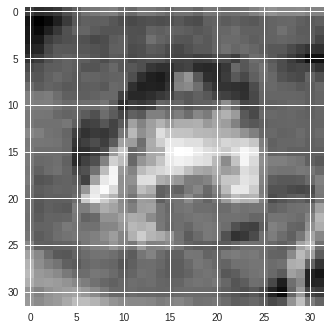

In [6]:
from cifar_loading import *
import matplotlib.pyplot as plt
nonFaceTrainData,nonFaceTrainLabel = load_CIFAR_batch('./data_batch_1')
nonFaceTrainData
nonFaceTrainData = np.apply_along_axis(weightedAverage, 3, nonFaceTrainData)
plt.gray()

plt.imshow(nonFaceTrainData[0]);
nonFaceTrainData


### Step 2: Generate the Data Matrix and the Label vector 

(32, 32)

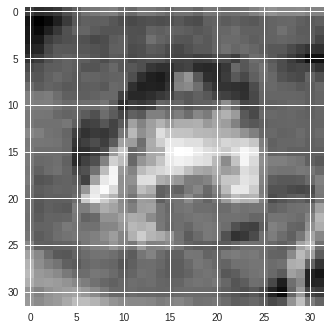

In [7]:
plt.imshow(nonFaceTrainData[0][:][:]);
nonFaceTrainData[0].shape

In [0]:
import cv2
resizedNonFaceData=np.arange(10000*10304).reshape(10000,10304)
for i in range(0,10000):
  resizedNonFaceData[i] = (cv2.resize(nonFaceTrainData[i], dsize=(112, 92), interpolation=cv2.INTER_CUBIC)).flatten()

In [0]:
import numpy as np
dataMatrix = np.arange(400*10304).reshape(400,10304)

label = []
for i in range(0,400) :
    dataMatrix[i] = np.array(imgs[i]).flatten()
    label.append(1)
dataMatrix=np.concatenate((dataMatrix,resizedNonFaceData[0:400,:]))
for i in range(400,800) :
    label.append(2)



### Step 3: Splitting the dataset into training and test sets

In [0]:
trainSet=np.arange(400*10304).reshape(400,10304)
testSet=np.arange(400*10304).reshape(400,10304)
trainLabel=[]
testLabel=[]
j,k=0,0
for i in range(0,800):
    if(i%2==0):
        testSet[j]=dataMatrix[i]
        testLabel.append(label[i])
        j+=1
    else:
        trainSet[k]=dataMatrix[i]
        trainLabel.append(label[i])
        k+=1

### Step 4: Classification using PCA

In [0]:
#calculate mean face of the training set.
trainMean=np.mean(trainSet,axis=0)
#subtract the mean face from the training set.
centerTrainMatrix=trainSet-trainMean
#compute the covariance matrix from obtained centered data matrix.
covMatrix=np.cov(centerTrainMatrix, rowvar=False, bias=True)


In [0]:
#displaying the mean face of the training data set.
plt.imshow(trainMean.reshape(112,92), cmap='gray');

In [0]:
#compute eigen vectors and values from obtained covariance matrix.
eigVal,eigVectMatrix=np.linalg.eigh(covMatrix)
#flip both eigen values and vectors in order to be sorted descendingly.
eigVal=np.flip(eigVal,axis=0)
eigVectMatrix=np.flip(eigVectMatrix,axis=1)

In [0]:
#displaying the largest three eigen vectors as images.
eigenFace1 = eigVectMatrix[:,0].reshape(112,92)
eigenFace2 = eigVectMatrix[:,1].reshape(112,92)
eigenFace3 = eigVectMatrix[:,2].reshape(112,92)
plt.imshow(eigenFace1, cmap='gray');
plt.figure()
plt.imshow(eigenFace2, cmap='gray');
plt.figure()
plt.imshow(eigenFace3, cmap='gray');

In [0]:
#utility method to compute the dimenison required for the specificed alpha value. 
def computeDimensionality(eigVal,threshold):
    totalDataVariance=np.sum(eigVal)
    varianceFraction,numDim,eigValSum=0,1,0
    
    while(varianceFraction<threshold):
        eigValSum+=eigVal[numDim-1]
        varianceFraction=eigValSum/totalDataVariance
        numDim+=1
    return numDim

In [0]:
#Calculating dimension needed for four alpha values ( 0.8 , 0.85 , 0.9 , 0.95)
dimAlpha1=computeDimensionality(eigVal,0.8)
dimAlpha2=computeDimensionality(eigVal,0.85)
dimAlpha3=computeDimensionality(eigVal,0.9)
dimAlpha4=computeDimensionality(eigVal,0.95)


In [0]:
#Computing the projection matrix, one for each alpha value.
projMat1=eigVectMatrix[:,0:dimAlpha1]
projMat2=eigVectMatrix[:,0:dimAlpha2]
projMat3=eigVectMatrix[:,0:dimAlpha3]
projMat4=eigVectMatrix[:,0:dimAlpha4]

In [0]:
#Projecting the tarining data instances on the new basis.
reducedDimTrain1= (projMat1.T @ centerTrainMatrix.T)
reducedDimTrain2= (projMat2.T @ centerTrainMatrix.T)
reducedDimTrain3= (projMat3.T @ centerTrainMatrix.T)
reducedDimTrain4= (projMat4.T @ centerTrainMatrix.T)

In [0]:
#calculate mean face of the test set.
testMean = np.mean(testSet,axis=0)
#subtract the mean face from the test set to obtain centered data matrix
centerTestMatrix = testSet-testMean
#Projecting the test data instances on the new basis.
reducedDimTest1=projMat1.T @ centerTestMatrix.T
reducedDimTest2=projMat2.T @ centerTestMatrix.T
reducedDimTest3=projMat3.T @ centerTestMatrix.T
reducedDimTest4=projMat4.T @ centerTestMatrix.T

In [0]:
#Reconstruction of a face using PCA eigen vectors ,where alpha = 0.95 
reconstrutedfaces = (reducedDimTrain4.T @ projMat4.T ) + trainMean
#Comparing the reconstructed face and the original face 
plt.imshow(reconstrutedfaces[50].reshape(112,92), cmap='gray');
plt.figure()
plt.imshow(trainSet[50].reshape(112,92), cmap='gray');

In [0]:
#import the KNeighborsClassifier class from sklearn
from sklearn.neighbors import KNeighborsClassifier
#import metrics model to check the accuracy 
from sklearn import metrics
# utility method to apply the knn classifier and return the score resulted.
def knn(trainingSet,trainingLabel,testSet,testLabel,k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(trainingSet,trainLabel)
    pred=knn.predict(testSet)
    score  = metrics.accuracy_score(testLabel,pred)
    return score

In [0]:
knn(reducedDimTrain1.T,trainLabel,reducedDimTest1.T,testLabel,1)

0.8475

In [0]:
knn(reducedDimTrain2.T,trainLabel,reducedDimTest2.T,testLabel,1)

0.8475

In [0]:
knn(reducedDimTrain3.T,trainLabel,reducedDimTest3.T,testLabel,1)

0.875

In [0]:
knn(reducedDimTrain4.T,trainLabel,reducedDimTest4.T,testLabel,1)

0.875

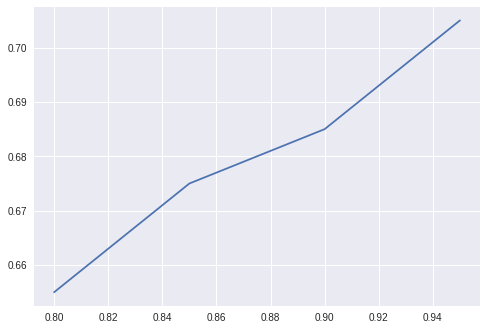

In [0]:
import matplotlib.pyplot as plt
plt.plot([0.8,0.85,0.9,0.95],[0.655,0.675,0.685,0.705]);

### Step 5: Classification using LDA

In [0]:

dataClassList=[]
dataClassList.append(trainSet[0:200,:])
dataClassList.append(trainSet[200:400,:])


In [0]:
mean=[]
mean.append(np.mean(trainSet[0:200,:],axis=0))
mean.append(np.mean(trainSet[200:400,:],axis=0))


In [0]:
withinClassScatterMatrix = np.zeros((10304,10304))
for i in range(0,2):
    diffMatrix = (dataClassList[i]-mean[i])
    withinClassScatterMatrix += diffMatrix.T @ diffMatrix

In [0]:
betweenClassScatterMatrix = np.zeros((10304,10304))
betweenClassScatterMatrix=np.outer(mean[0]-mean[1],mean[0]-mean[1])

In [0]:
withinClassScatterMatrixInv = np.linalg.pinv(withinClassScatterMatrix)

####Approach 1 : Calculating the best linear discriminant using the eigenvalue problem $(S^{-1}B)w=\lambda w$

In [0]:
sinverse_b = withinClassScatterMatrixInv @ betweenClassScatterMatrix

In [0]:
eigValLDA,eigVectMatrixLDA = np.linalg.eig(sinverse_b)

In [0]:
idx = eigValLDA.argmax()
linearDiscriminant = np.real(eigVectMatrixLDA[:,idx])

####Approach 2 : By using some simple linear algebra it can be found that $w=S^{-1}(\mu_1-\mu_2)$ in a 2 class problem

In [0]:
linearDiscriminant=withinClassScatterMatrixInv @ (mean[0]-mean[1])
linearDiscriminant=linearDiscriminant/np.linalg.norm(linearDiscriminant)

####Calculating the coordinates of the data in the new dimensions, using knn to classify the test data and outputting the accuracy

In [0]:
reducedDimTrainLDA = linearDiscriminant.T @ trainSet.T
reducedDimTestLDA = linearDiscriminant.T @ testSet.T

In [25]:
knn(reducedDimTrainLDA.reshape(-1, 1),trainLabel,reducedDimTestLDA.reshape(-1, 1),testLabel,1)

0.5375

### Step 6: Classifier Tuning 

In [0]:
LDAscoreList = []
for k in range(1,8,2):
    LDAscoreList.append(knn(reducedDimTrainLDA.T,trainLabel,reducedDimTestLDA.T,testLabel,k))

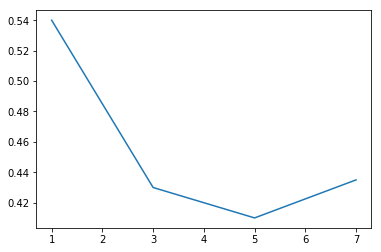

In [0]:
plt.plot([1,3,5,7],LDAscoreList);

In [0]:
PCAscoreList = []
for k in range(1,8,2):
    PCAscoreList.append(knn(reducedDimTrain4.T,trainLabel,reducedDimTest4.T,testLabel,k))

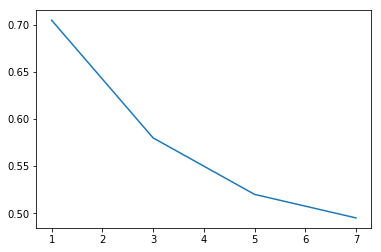

In [0]:
plt.plot([1,3,5,7],PCAscoreList);